In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

import warnings

# ML Libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Models
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Naive Bayes
from sklearn.naive_bayes import GaussianNB

# KNN
from sklearn.neighbors import KNeighborsClassifier

#pip install miceforest
from miceforest import ImputationKernel

import sqlite3

warnings.filterwarnings('ignore')

In [2]:
con = sqlite3.connect('Resources/database.db')
raw = pd.read_sql_query('SELECT*FROM players', con)
original = raw.copy()
len(raw)

5222

In [3]:
raw.head()

,player_id,player_name,year,School,position_combine,height,ht,weight,forty_yard,vertical_leap,...,position_nfl,position_nfl_std,bench_press_score,broad_jump_score,forty_yard_score,shuttle_run_score,three_cone_score,vertical_leap_score,combine_score,draft_pick_flag
0,2000ABRAHAMJOHNSOU,John Abraham,2000,South Carolina,OLB,6 ft 4 in,76,252.0,4.55,34.5,...,DE,DE,NaN,NaN,4.0,NaN,NaN,NaN,NaN,1
1,2000ALEXANDERSHAUNALA,Shaun Alexander,2000,Alabama,RB,6 ft 0 in,72,218.0,4.58,35.0,...,RB,RB,NaN,NaN,2.0,NaN,NaN,NaN,NaN,1
2,2000ALFORDDARNELLBOS,Darnell Alford,2000,Boston Col.,OT,6 ft 4 in,76,334.0,5.56,25.0,...,G,G,2.0,1.0,1.0,1.0,1.0,1.0,7.0,1
3,2000ALLAMONKYLETEX,Kyle Allamon,2000,Texas Tech,TE,6 ft 2 in,74,253.0,4.97,29.0,...,None,None,NaN,1.0,1.0,1.0,2.0,1.0,NaN,0
4,2000ANDERSONRASHARDJAC,Rashard Anderson,2000,Jackson State,CB,6 ft 2 in,74,206.0,4.55,34.0,...,DB,DB,NaN,3.0,2.0,3.0,1.0,2.0,NaN,1


In [4]:
#Data Exploration: 
num_nans = raw.isna().sum()
print('Count of missing values for each columns:')
print(num_nans)

Count of missing values for each columns:
player_id                 0
player_name               0
year                      0
School                    0
position_combine          0
height                    0
ht                        0
weight                    0
forty_yard                0
vertical_leap            52
bench_press               0
broad_jump               52
three_cone                0
shuttle_run               0
draft_round            2304
draft_pick             2304
nfl_team               2304
position_nfl           2304
position_nfl_std       2304
bench_press_score      1746
broad_jump_score       1257
forty_yard_score         48
shuttle_run_score      1781
three_cone_score       1824
vertical_leap_score    1229
combine_score          2782
draft_pick_flag           0
dtype: int64


In [5]:
raw = raw.dropna(subset = ['draft_round', 'forty_yard', 'vertical_leap', 'bench_press', 'broad_jump', 'three_cone', 'shuttle_run'], how = 'all')
raw.isna().sum()

player_id                 0
player_name               0
year                      0
School                    0
position_combine          0
height                    0
ht                        0
weight                    0
forty_yard                0
vertical_leap            52
bench_press               0
broad_jump               52
three_cone                0
shuttle_run               0
draft_round            2304
draft_pick             2304
nfl_team               2304
position_nfl           2304
position_nfl_std       2304
bench_press_score      1746
broad_jump_score       1257
forty_yard_score         48
shuttle_run_score      1781
three_cone_score       1824
vertical_leap_score    1229
combine_score          2782
draft_pick_flag           0
dtype: int64

In [6]:
raw.draft_round.unique()

array([ 1.,  6., nan,  4.,  7.,  2.,  5.,  3.])

In [7]:
raw.isna().sum()
#drop 'draft_pick', 'position_nfl'

raw.drop(columns=['draft_pick', 'position_nfl', 'bench_press_score', 'broad_jump_score',
                  'forty_yard_score', 'shuttle_run_score', 'three_cone_score', 'vertical_leap_score'], inplace=True)

In [8]:
raw.isna().sum()

player_id              0
player_name            0
year                   0
School                 0
position_combine       0
height                 0
ht                     0
weight                 0
forty_yard             0
vertical_leap         52
bench_press            0
broad_jump            52
three_cone             0
shuttle_run            0
draft_round         2304
nfl_team            2304
position_nfl_std    2304
combine_score       2782
draft_pick_flag        0
dtype: int64

In [9]:
# 4278 undrafted --> draft round 8 (gulag)

raw['draft_round'] = raw['draft_round'].fillna(8)
raw['position_nfl_std'] = raw['position_nfl_std'].fillna('Undrafted')
raw['nfl_team'] = raw['nfl_team'].fillna('Undrafted')

In [10]:
raw.describe()

,year,ht,weight,forty_yard,vertical_leap,bench_press,broad_jump,three_cone,shuttle_run,draft_round,combine_score,draft_pick_flag
count,5222.000000,5222.000000,5222.000000,5222.000000,5170.000000,5222.000000,5170.00000,5222.000000,5222.000000,5222.000000,2440.000000,5222.000000
mean,2007.527576,73.758522,243.799502,4.787176,32.795551,20.439008,113.37882,7.268168,4.373911,5.695902,15.496721,0.558790
std,4.598650,2.630851,45.292074,0.305898,3.991646,5.947607,8.89286,0.391447,0.246991,2.519607,4.237805,0.496579
min,2000.000000,65.000000,149.000000,4.220000,17.500000,2.000000,74.00000,6.340000,3.730000,1.000000,6.000000,0.000000
25%,2004.000000,72.000000,206.000000,4.550000,30.000000,15.000000,108.00000,6.990000,4.200000,3.000000,12.000000,0.000000
50%,2008.000000,74.000000,234.000000,4.710000,33.500000,20.000000,115.00000,7.160000,4.320000,7.000000,16.000000,1.000000
75%,2012.000000,76.000000,281.000000,4.990000,35.500000,24.000000,120.00000,7.500000,4.520000,8.000000,19.000000,1.000000
max,2015.000000,82.000000,375.000000,6.050000,46.000000,49.000000,147.00000,9.120000,5.560000,8.000000,24.000000,1.000000


<Axes: >

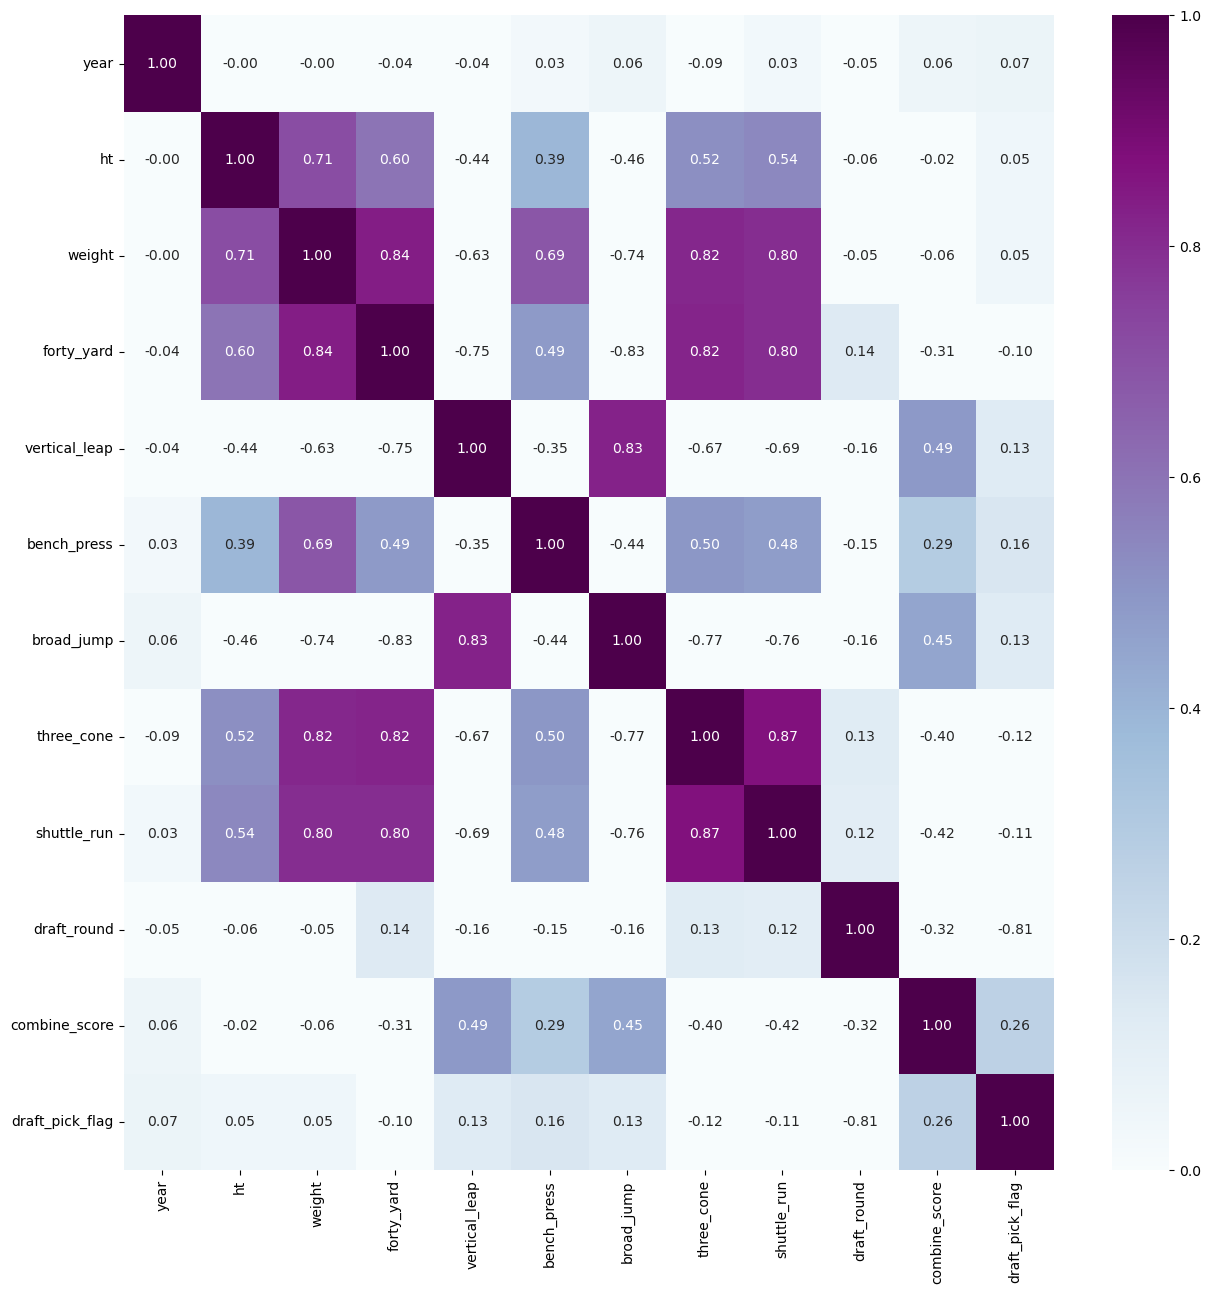

In [11]:
# Correlation Matrix
plt.figure(figsize=(15, 15))

corr_data = raw.copy()
corr_data
sns.heatmap(corr_data.corr(), cmap = 'BuPu', annot=True, fmt = '.2f', vmin=0)

# drop weight, drop shuttle run

In [12]:
# drop weight, drop shuttle run
# final features
drop_cols = ['player_id', 'School', 'player_name', 'height', 'three_cone', 'shuttle_run']


In [13]:
# preprocessing 
temp = raw.drop(drop_cols, axis=1)
obj_df = temp.select_dtypes(include = ['object']).copy()
obj_df['position_combine'] = obj_df['position_combine'].astype('category').cat.codes
obj_df['nfl_team'] = obj_df['nfl_team'].astype('category').cat.codes
obj_df['position_nfl_std'] = obj_df['position_nfl_std'].astype('category').cat.codes
obj_df.head()

,position_combine,nfl_team,position_nfl_std
0,9,21,2
1,13,26,11
2,10,15,5
3,15,31,14
4,1,4,1


In [14]:
temp.dtypes

year                  int64
position_combine     object
ht                    int64
weight              float64
forty_yard          float64
vertical_leap       float64
bench_press         float64
broad_jump          float64
draft_round         float64
nfl_team             object
position_nfl_std     object
combine_score       float64
draft_pick_flag       int64
dtype: object

In [15]:
features_df = temp.select_dtypes(include = ['int', 'float']).copy()
obj_df
features_df

df = pd.concat([features_df, obj_df], axis=1)
df.head()


median_imp = df.copy()
df_na = df.copy()

Using *Mice Imputation* To Fill in Data

In [16]:
mk = ImputationKernel(
    data = df,
    save_all_iterations=True
)

In [17]:
mk.mice(2)
mice_imputation = mk.complete_data()
mice_imputation.head()

,year,ht,weight,forty_yard,vertical_leap,bench_press,broad_jump,draft_round,combine_score,draft_pick_flag,position_combine,nfl_team,position_nfl_std
0,2000,76,252.0,4.55,34.5,23.0,118.0,1.0,19.0,1,9,21,2
1,2000,72,218.0,4.58,35.0,20.0,119.0,1.0,18.0,1,13,26,11
2,2000,76,334.0,5.56,25.0,23.0,94.0,6.0,7.0,1,10,15,5
3,2000,74,253.0,4.97,29.0,19.5,104.0,8.0,6.0,0,15,31,14
4,2000,74,206.0,4.55,34.0,15.0,123.0,1.0,12.0,1,1,4,1


In [18]:
df = mice_imputation.copy()

In [19]:
X = df.drop('draft_round', axis=1)
y = df['draft_round']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
# Decision Tree
md = df['draft_round'].nunique()
tree = DecisionTreeClassifier(max_depth=md)

tree.fit(X_train, y_train)

pred_tree = tree.predict(X_test)

acc_tree = accuracy_score(pred_tree, y_test)

print(acc_tree)

0.5617224880382775


In [21]:
# Naive Bayes
clf_nb = GaussianNB()

#fit model
clf_nb.fit(X_train, y_train)

#predictions
pred_nb = clf_nb.predict(X_test)

#acc score
acc_nb = accuracy_score(pred_nb, y_test)


print(acc_nb)

0.5368421052631579


In [22]:
# KNN
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(pred_knn, y_test)

print(acc_knn)


0.5244019138755981


In [23]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(pred_rf, y_test)

print(acc_rf)

0.5435406698564593


Using *Median Imputation* to fill Nans

In [24]:
median_imp.head()

,year,ht,weight,forty_yard,vertical_leap,bench_press,broad_jump,draft_round,combine_score,draft_pick_flag,position_combine,nfl_team,position_nfl_std
0,2000,76,252.0,4.55,34.5,23.0,118.0,1.0,NaN,1,9,21,2
1,2000,72,218.0,4.58,35.0,20.0,119.0,1.0,NaN,1,13,26,11
2,2000,76,334.0,5.56,25.0,23.0,94.0,6.0,7.0,1,10,15,5
3,2000,74,253.0,4.97,29.0,19.5,104.0,8.0,NaN,0,15,31,14
4,2000,74,206.0,4.55,34.0,15.0,123.0,1.0,NaN,1,1,4,1


In [25]:
median_val = median_imp.median()
med_df = median_imp.fillna(median_val)
med_df.head()

,year,ht,weight,forty_yard,vertical_leap,bench_press,broad_jump,draft_round,combine_score,draft_pick_flag,position_combine,nfl_team,position_nfl_std
0,2000,76,252.0,4.55,34.5,23.0,118.0,1.0,16.0,1,9,21,2
1,2000,72,218.0,4.58,35.0,20.0,119.0,1.0,16.0,1,13,26,11
2,2000,76,334.0,5.56,25.0,23.0,94.0,6.0,7.0,1,10,15,5
3,2000,74,253.0,4.97,29.0,19.5,104.0,8.0,16.0,0,15,31,14
4,2000,74,206.0,4.55,34.0,15.0,123.0,1.0,16.0,1,1,4,1


In [26]:
X = med_df.drop('draft_round', axis=1)
y = med_df['draft_round']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [27]:
#Decision tree median
med_md = df['draft_round'].nunique()
med_tree = DecisionTreeClassifier(max_depth=md)
med_tree.fit(X_train, y_train)
med_pred_tree = med_tree.predict(X_test)
med_acc_tree = accuracy_score(med_pred_tree, y_test)
print(med_acc_tree)

0.538755980861244


In [28]:
# Naive Bayes Median
med_nb = GaussianNB()
med_nb.fit(X_train, y_train)
med_pred_nb = med_nb.predict(X_test)
med_acc_nb = accuracy_score(med_pred_nb, y_test)
print(med_acc_nb)

0.5177033492822967


In [29]:
# KNN Median
knn.fit(X_train, y_train)
med_pred_knn = knn.predict(X_test)
med_acc_knn = accuracy_score(med_pred_knn, y_test)
print(med_acc_knn)

0.49569377990430624


In [30]:
# Random Forest

rf.fit(X_train, y_train)
med_pred_rf = rf.predict(X_test)
pred_acc_rf = accuracy_score(med_pred_rf, y_test)

print(pred_acc_rf)

0.5339712918660288


Seems like the models perform about the same using both methods to fill in data.

Let's see if scaling X will help our models

In [31]:
mice_imputation.head()

,year,ht,weight,forty_yard,vertical_leap,bench_press,broad_jump,draft_round,combine_score,draft_pick_flag,position_combine,nfl_team,position_nfl_std
0,2000,76,252.0,4.55,34.5,23.0,118.0,1.0,19.0,1,9,21,2
1,2000,72,218.0,4.58,35.0,20.0,119.0,1.0,18.0,1,13,26,11
2,2000,76,334.0,5.56,25.0,23.0,94.0,6.0,7.0,1,10,15,5
3,2000,74,253.0,4.97,29.0,19.5,104.0,8.0,6.0,0,15,31,14
4,2000,74,206.0,4.55,34.0,15.0,123.0,1.0,12.0,1,1,4,1


In [32]:
scale_df = mice_imputation.copy()

scaler = StandardScaler()

X = scale_df.drop('draft_round', axis=1)
y = df['draft_round']

scaler.fit(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [33]:
#Decision tree scaled

scale_tree = DecisionTreeClassifier(max_depth=md)
scale_tree.fit(X_train, y_train)
scale_pred_tree = scale_tree.predict(X_test)
scale_acc_tree = accuracy_score(scale_pred_tree, y_test)
print(scale_acc_tree)

0.539712918660287


In [34]:
# Naive Bayes Scaled
scale_nb = GaussianNB()
scale_nb.fit(X_train, y_train)
scale_pred_nb = scale_nb.predict(X_test)
scale_acc_nb = accuracy_score(scale_pred_nb, y_test)
print(scale_acc_nb)

0.5311004784688995


In [35]:
# KNN Median Scale
knn.fit(X_train, y_train)
scale_pred_knn = knn.predict(X_test)
scale_acc_knn = accuracy_score(scale_pred_knn, y_test)
print(scale_acc_knn)

0.49569377990430624


In [36]:
# Random Forest Scale

rf.fit(X_train, y_train)
scale_pred_rf = rf.predict(X_test)
scale_acc_rf = accuracy_score(scale_pred_rf, y_test)

print(scale_acc_rf)

0.538755980861244


Still about the same ...
Let's drop all Nans. This will normalize the data, but exclude a large chunck of our data and pretty much unusable since it's not realistic

In [37]:
con = sqlite3.connect('Resources/database.db')
df_na_total = pd.read_sql_query('SELECT*FROM players_raw', con)

In [38]:
df_na_total.dropna(inplace=True)
df_na_total.isna().sum()

player_id              0
player_name            0
year                   0
School                 0
position_combine       0
height                 0
ht                     0
weight                 0
forty_yard             0
vertical_leap          0
bench_press            0
broad_jump             0
three_cone             0
shuttle_run            0
draft_round            0
draft_pick             0
nfl_team               0
position_nfl           0
position_nfl_std       0
bench_press_score      0
broad_jump_score       0
forty_yard_score       0
shuttle_run_score      0
three_cone_score       0
vertical_leap_score    0
combine_score          0
draft_pick_flag        0
dtype: int64

In [39]:
df_na_total.groupby(by = 'position_combine')['player_id'].count()


position_combine
C       52
CB     163
DE     145
DT     129
FB      33
ILB     64
LS       1
OG     114
OLB    147
OT     155
QB       2
RB     113
S      113
TE      93
WR     107
Name: player_id, dtype: int64

In [40]:
#drop QB and LS since there is little data
df_na_total = df_na_total[(df_na['position_combine']!= 'LS') & (df_na_total['position_combine'] != 'QB')]
df_na_total.head()

,player_id,player_name,year,School,position_combine,height,ht,weight,forty_yard,vertical_leap,...,position_nfl,position_nfl_std,bench_press_score,broad_jump_score,forty_yard_score,shuttle_run_score,three_cone_score,vertical_leap_score,combine_score,draft_pick_flag
2,2000ALFORDDARNELLBOS,Darnell Alford,2000,Boston Col.,OT,6 ft 4 in,76,334.0,5.56,25.0,...,G,G,2.0,1.0,1.0,1.0,1.0,1.0,7.0,1
9,2000AUSTINREGGIEWAK,Reggie Austin,2000,Wake Forest,CB,5 ft 9 in,69,175.0,4.44,35.0,...,DB,DB,4.0,2.0,3.0,3.0,2.0,2.0,16.0,1
11,2000BANIEWICZMARKSYR,Mark Baniewicz,2000,Syracuse,OT,6 ft 6 in,78,312.0,5.34,28.0,...,T,T,1.0,1.0,2.0,3.0,3.0,3.0,13.0,1
12,2000BARNESRASHIDICOL,Rashidi Barnes,2000,Colorado,S,6 ft 0 in,72,208.0,4.62,35.0,...,DB,DB,1.0,1.0,2.0,1.0,3.0,2.0,10.0,1
13,2000BARRETTDAVIDARK,David Barrett,2000,Arkansas,CB,5 ft 10 in,70,199.0,4.44,37.5,...,DB,DB,3.0,1.0,3.0,4.0,4.0,3.0,18.0,1


In [41]:
#preprocessing
drop_cols = ['player_id', 'School', 'player_name', 'height', 'shuttle_run', 'three_cone', 'weight',
             'draft_pick_flag', 'vertical_leap_score', 'three_cone_score', 'shuttle_run_score', 'forty_yard_score',
             'broad_jump_score', 'bench_press_score', 'position_nfl']
temp = df_na_total.drop(drop_cols, axis=1)
obj_df = temp.select_dtypes(include = ['object']).copy()
obj_df['position_combine'] = obj_df['position_combine'].astype('category').cat.codes
obj_df['nfl_team'] = obj_df['nfl_team'].astype('category').cat.codes
obj_df['position_nfl_std'] = obj_df['position_nfl_std'].astype('category').cat.codes
obj_df.head()

,position_combine,nfl_team,position_nfl_std
2,9,15,5
9,1,5,1
11,9,14,8
12,11,7,1
13,1,0,1


In [42]:
features_df = temp.select_dtypes(include = ['int', 'float']).copy()
obj_df
features_df

df_na_total = pd.concat([features_df, obj_df], axis=1)

In [43]:
# drop all nans and drop all 'draft_round = 8'
df_na_total.dropna(inplace=True)
df_na_total = df_na_total[df_na_total['draft_round']!=8]
df_na = df_na_total[df_na_total['year']<2015]

In [44]:
df_na.describe()

,year,ht,forty_yard,vertical_leap,bench_press,broad_jump,draft_round,draft_pick,combine_score,position_combine,nfl_team,position_nfl_std
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,2007.773313,74.094011,4.795921,32.921531,22.004549,113.452616,4.018954,119.558757,16.408643,6.684610,15.372252,4.805914
std,4.348898,2.696080,0.318608,4.228546,6.555701,9.290979,1.929431,69.405776,4.019748,4.111016,9.369591,3.098327
min,2000.000000,65.000000,4.260000,21.000000,2.000000,85.000000,1.000000,1.000000,6.000000,0.000000,0.000000,0.000000
25%,2005.000000,72.000000,4.530000,30.000000,17.000000,107.000000,2.000000,61.000000,13.000000,2.000000,7.000000,2.000000
50%,2008.000000,74.000000,4.710000,33.500000,22.000000,115.000000,4.000000,115.000000,17.000000,8.000000,15.000000,5.000000
75%,2012.000000,76.000000,5.060000,36.000000,26.000000,120.000000,6.000000,176.000000,19.000000,10.000000,24.000000,7.000000
max,2014.000000,80.000000,5.650000,43.500000,45.000000,139.000000,7.000000,259.000000,24.000000,13.000000,31.000000,10.000000


<Axes: >

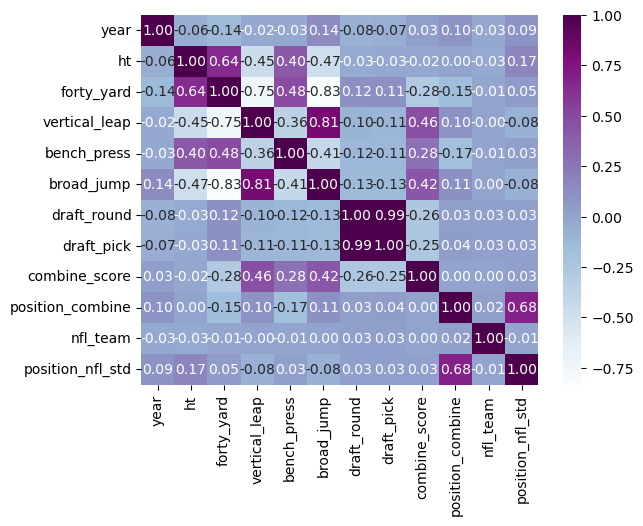

In [45]:
sns.heatmap(df_na.corr(), cmap = 'BuPu', annot=True, fmt = '.2f', vmax=True)

In [46]:
len(df_na)

1319

In [47]:
scaler = StandardScaler()

X = df_na.drop('draft_round', axis=1)
y = df_na['draft_round']

scaler.fit(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [48]:
#Decision tree drop nans
md = y.nunique()
na_tree = DecisionTreeClassifier(max_depth=md)
na_tree.fit(X_train, y_train)
na_pred_tree = na_tree.predict(X_test)
na_acc_tree = accuracy_score(na_pred_tree, y_test)
print(na_acc_tree)

0.9545454545454546


In [49]:
# Naive Bayes drop nans
na_nb = GaussianNB()
na_nb.fit(X_train, y_train)
na_pred_nb = na_nb.predict(X_test)
na_acc_nb = accuracy_score(na_pred_nb, y_test)
print(na_acc_nb)

0.9507575757575758


In [50]:
# KNN Drop Nans
knn.fit(X_train, y_train)
na_pred_knn = knn.predict(X_test)
na_acc_knn = accuracy_score(na_pred_knn, y_test)
print(na_acc_knn)

0.9242424242424242


In [51]:
# Random Forest drop Nans

rf.fit(X_train, y_train)
na_pred_rf = rf.predict(X_test)
na_acc_rf = accuracy_score(na_pred_rf, y_test)

print(na_acc_rf)

pred_df = pd.DataFrame({
    'predicted': na_pred_rf,
    'actual': y_test,
    'difference': (na_pred_rf - y_test)
})



0.9583333333333334


In [52]:
pred_df.drop(columns='difference')

,predicted,actual
2026,6.0,6.0
225,7.0,7.0
1827,3.0,3.0
1990,2.0,2.0
4525,1.0,1.0
...,...,...
2139,7.0,7.0
4227,2.0,2.0
340,2.0,2.0
4399,3.0,3.0


In [53]:
pred_df[pred_df['difference']>0]

,predicted,actual,difference
4581,2.0,1.0,1.0
4318,3.0,1.0,2.0
787,6.0,5.0,1.0
2668,4.0,3.0,1.0


Testing on 2015 Data

In [55]:
testing = df_na_total[df_na_total['year']==2015]

In [56]:
testing.head()

,year,ht,forty_yard,vertical_leap,bench_press,broad_jump,draft_round,draft_pick,combine_score,position_combine,nfl_team,position_nfl_std
4900,2015,69,4.60,42.5,24.0,130.0,2.0,54.0,22.0,10,10,7
4902,2015,72,4.57,39.0,19.0,121.0,5.0,149.0,18.0,10,16,7
4903,2015,73,4.55,36.0,24.0,121.0,4.0,124.0,18.0,8,29,6
4904,2015,68,4.43,34.0,13.0,121.0,7.0,238.0,19.0,13,6,10
4905,2015,72,4.53,35.5,11.0,121.0,4.0,125.0,15.0,10,2,7


In [57]:
testing_x = testing.drop('draft_round', axis=1)
testing_y = testing['draft_round']

In [58]:
pred2015 = rf.predict(testing_x)

In [59]:
accuracy_score(testing_y, pred2015)

0.9454545454545454

In [66]:
pred_actual = pd.DataFrame({
    'predicted': pred2015,
    'actual': testing_y,
    'isDifferent': (pred2015-testing_y)
})
pred_actual

,predicted,actual,isDifferent
4900,2.0,2.0,0.0
4902,5.0,5.0,0.0
4903,4.0,4.0,0.0
4904,7.0,7.0,0.0
4905,4.0,4.0,0.0
...,...,...,...
5211,2.0,2.0,0.0
5212,3.0,3.0,0.0
5214,4.0,4.0,0.0
5219,4.0,4.0,0.0


In [65]:
pred_actual[pred_actual['isDifferent']!= 0]

,predicted,actual,isDifferent
4918,4.0,5.0,-1.0
4944,7.0,6.0,1.0
5012,7.0,6.0,1.0
5033,7.0,6.0,1.0
5121,7.0,6.0,1.0
5149,3.0,2.0,1.0
